In [90]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
from sklearn.manifold import TSNE

# from sklearn.metrics import accuracy_score
# from sklearn.linear_model import LogisticRegression
# from sklearn.neighbors import KNeighborsClassifier

from local_python.dataset_util import (
    create_dataloaders,
)
from local_python.plot_utils import plot_tsne_scatter

In [3]:
seed = 19
features_root_path = "../datasets/intermediate-features"

csv_paths = os.listdir(features_root_path)
csv_paths

['Cassava-ResNet50-Derma_SSL_SimCLR.csv',
 'Cassava-ResNet50-ImageNet_1k_SL_V1.csv',
 'Cassava-ResNet50-ImageNet_1k_SSL_SimCLR.csv',
 'Cassava-ResNet50-PDDD.csv',
 'Cassava-ResNet50-Random.csv',
 'Cassava-ViT_T16-Derma.csv',
 'Cassava-ViT_T16-ImageNet_1k_SL_WinKawaks.csv',
 'Cassava-ViT_T16-ImageNet_1k_SSL_Dino.csv',
 'Cassava-ViT_T16-ImageNet_AugReg.csv',
 'Cassava-ViT_T16-Plant.csv',
 'Cassava-ViT_T16-Random.csv',
 'Cassava-ViT_T16-teacher-Derma.csv',
 'Cassava-ViT_T16-teacher-ImageNet_1k_SSL_Dino.csv',
 'Cassava-ViT_T16-teacher-Plant.csv',
 'DDI-ResNet50-Derma_SSL_SimCLR.csv',
 'DDI-ResNet50-ImageNet_1k_SL_V1.csv',
 'DDI-ResNet50-ImageNet_1k_SSL_SimCLR.csv',
 'DDI-ResNet50-PDDD.csv',
 'DDI-ResNet50-Random.csv',
 'DDI-ViT_T16-Derma.csv',
 'DDI-ViT_T16-ImageNet_1k_SL_WinKawaks.csv',
 'DDI-ViT_T16-ImageNet_1k_SSL_Dino.csv',
 'DDI-ViT_T16-ImageNet_AugReg.csv',
 'DDI-ViT_T16-Plant.csv',
 'DDI-ViT_T16-Random.csv',
 'DDI-ViT_T16-teacher-Derma.csv',
 'DDI-ViT_T16-teacher-ImageNet_1k_SSL_Din

In [4]:
def beautify_names(name):
    return re.sub(r"_+", " ", re.sub(r"\(.*\)", "", name))

In [26]:
dataset_features_paths = [
    os.path.join(features_root_path, csv_paths[idx]) for idx in [102, 99, 101, 98]
]
dataset_features_paths

['../datasets/intermediate-features\\PlantVillage-ResNet50-Random.csv',
 '../datasets/intermediate-features\\PlantVillage-ResNet50-ImageNet_1k_SL_V1.csv',
 '../datasets/intermediate-features\\PlantVillage-ResNet50-PDDD.csv',
 '../datasets/intermediate-features\\PlantVillage-ResNet50-Derma_SSL_SimCLR.csv']

In [27]:
df_full_array = [
    pd.read_csv(dataset_features_path, index_col=0)
    for dataset_features_path in dataset_features_paths
]

In [28]:
selection_list = [
    label
    for i, label in enumerate(df_full_array[0]["target_code"].unique())
    if i in [13, 26, 29, 31]
]
selection_list

['Grape___healthy',
 'Strawberry___healthy',
 'Tomato___Early_blight',
 'Tomato___Late_blight']

In [34]:
df_devel_array = [
    df_full[
        ((df_full["set"] == "train") | (df_full["set"] == "valid"))
        & (df_devel["target_code"].isin(selection_list))
    ]
    for df_full in df_full_array
]

features_array = [df_devel.loc[:, ~df_devel.columns.isin(["target_code", "set"])] for df_devel in df_devel_array]
targets_array = [df_devel["target_code"] for df_devel in df_devel_array]

label_map = {
    label: idx for idx, label in enumerate(df_devel_array[0]["target_code"].unique())
}

label_map

{'Grape___healthy': 0,
 'Strawberry___healthy': 1,
 'Tomato___Early_blight': 2,
 'Tomato___Late_blight': 3}

In [38]:
number_of_samples = len(targets_array[0])  # 1000
sample_features_array = [
    features.sample(number_of_samples, random_state=seed, replace=False)
    for features in features_array
]
sample_targets_array = [
    targets.sample(number_of_samples, random_state=seed, replace=False)
    for targets in targets_array
]
color_list_array = [
    [label_map[label] for label in sample_targets]
    for sample_targets in sample_targets_array
]
string_labels_array = [
    [beautify_names(k) for k in label_map.keys() if k in set(sample_targets)]
    for sample_targets in sample_targets_array
]

In [39]:
features_reduced_array = [
    TSNE(n_components=2, random_state=seed).fit_transform(X=sample_features)
    for sample_features in sample_features_array
]

In [70]:
def plot_tsne_scatter_combined(features_reduced, color_list):
    scatter = plt.scatter(
        features_reduced[:, 0],
        features_reduced[:, 1],
        c=color_list,
        # s=None,
        cmap="jet",
    )
    plt.xticks([])
    plt.yticks([])
    return scatter.legend_elements(num=len(set(color_list)) - 1)

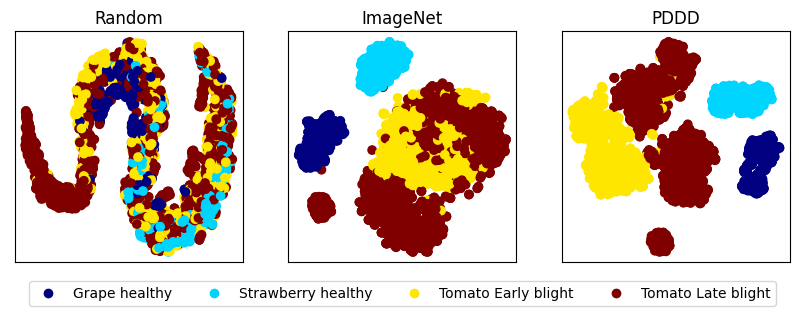

In [89]:
plt.figure(figsize=(10, 3))
title = f"Features visualized with tSNE"
titles = ["Random", "ImageNet", "PDDD"]

idx = 1
for i in [0,1,2]:
    plt.subplot(1, 3, idx)
    plt.title(titles[i])
    handles, labels_numbers = plot_tsne_scatter_combined(features_reduced_array[i], color_list_array[i])
    idx+=1

labels = string_labels_array[i]

plt.legend(
    handles=handles,
    labels=labels,
    # title="Label",
    loc="upper center", 
    bbox_to_anchor=(-0.7, -0.05), 
    ncol=len(labels)
)
filename = title.lower().replace(" ", "_") + "_combined.png"
plt.savefig(os.path.join(f"../images/", filename), bbox_inches="tight")
plt.show()

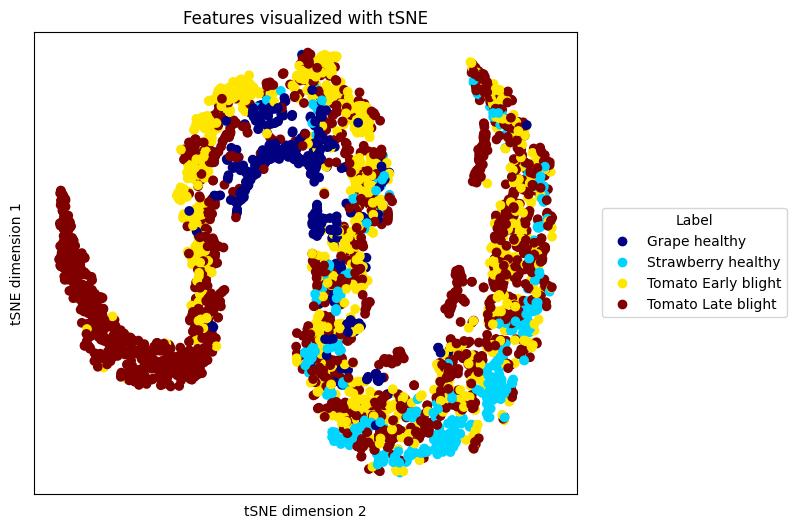

In [100]:
i = 0
plt.figure(figsize=(7, 6))
title = f"Features visualized with tSNE"
plt.title(title)
origin = os.path.splitext(os.path.basename(dataset_features_paths[i]))[0]
plot_tsne_scatter(features_reduced_array[i], color_list_array[i], string_labels_array[i])
filename = title.lower().replace(" ", "_") + f"_{origin}.png"
plt.savefig(os.path.join(f"../images/", filename), bbox_inches="tight")

In [261]:
stop

NameError: name 'stop' is not defined

Accuracy with 1 neighbors: 0.40233236151603496
Accuracy with 2 neighbors: 0.40816326530612246
Accuracy with 3 neighbors: 0.49271137026239065
Accuracy with 4 neighbors: 0.5393586005830904
Accuracy with 5 neighbors: 0.5539358600583091
Accuracy with 6 neighbors: 0.577259475218659
Accuracy with 7 neighbors: 0.5860058309037901
Accuracy with 8 neighbors: 0.5947521865889213
Accuracy with 9 neighbors: 0.5947521865889213
Accuracy with 10 neighbors: 0.5947521865889213
Accuracy with 11 neighbors: 0.6034985422740525
Accuracy with 12 neighbors: 0.6151603498542274
Accuracy with 13 neighbors: 0.6180758017492711
Accuracy with 14 neighbors: 0.6122448979591837
Accuracy with 15 neighbors: 0.6151603498542274


Text(0, 0.5, 'Accuracy')

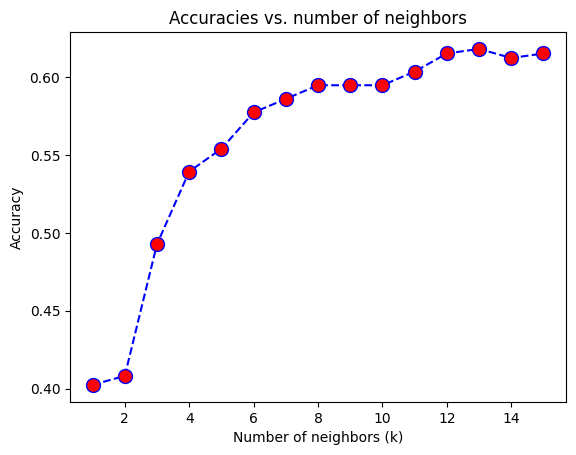

In [ ]:
accuracies = []
max_neighbors = 16
for i in range(1, max_neighbors):
    model_knn = KNeighborsClassifier(n_neighbors=i)
    model_knn.fit(train_features, df_train_targets)
    valid_pred = model_knn.predict(valid_features)
    accuracy = accuracy_score(df_valid_targets, valid_pred)
    accuracies.append(accuracy)
    print(f"Accuracy with {i} neighbors: {accuracy}")

# plt.figure(figsize=(10,6))
plt.plot(
    range(1, max_neighbors),
    accuracies,
    color="blue",
    linestyle="dashed",
    marker="o",
    markerfacecolor="red",
    markersize=10,
)
plt.title("Accuracies vs. number of neighbors")
plt.xlabel("Number of neighbors (k)")
plt.ylabel("Accuracy")
# ResNet Random_19 (K=1): 0.07036247334754797
# ResNet Random_20 (K=1): 0.053304904051172705
# ResNet Random_21 (K=1): 0.07462686567164178
# ResNet ImageNet_v1 (K=1): 0.15565031982942432
# ResNet ImageNet_v2 (K=1): 0.10660980810234541
# ResNet PDDD (K=1): 0.18976545842217485
# Swin_T Random_19 (K=1): 0.06823027718550106
# Swin_T Random_20 (K=1): 0.0767590618336887
# Swin_T Random_21 (K=1): 0.05543710021321962
# Swin_T ImageNet (K=1): 0.39872068230277186
# Swin_T PDDD (K=1): 0.2579957356076759

In [ ]:
model_lr = LogisticRegression(max_iter=10000)
model_lr.fit(train_features, df_train_targets)
valid_pred = model_lr.predict(valid_features)
accuracy = accuracy_score(df_valid_targets, valid_pred)
print(f"Accuracy: {accuracy}")
# ResNet Random_19: 0.0021321961620469083
# ResNet Random_20: 0.01279317697228145
# ResNet Random_21: 0.008528784648187633 ???
# ResNet ImageNet_v1: 0.008528784648187633 ???
# ResNet ImageNet_v2: 0.07889125799573561
# ResNet PDDD: 0.14285714285714285
# Swin_T Random_19: 0.1023454157782516
# Swin_T Random_20: 0.10660980810234541
# Swin_T Random_21: 0.12366737739872068
# Swin_T ImageNet: 0.5778251599147122
# Swin_T PDDD: 0.3411513859275053

Accuracy: 0.4956268221574344
